**Import Libraries**

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('max_colwidth', None)

import tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Load the data**

In [ ]:
path = '/content/drive/MyDrive/US_Airline_tweets.csv'

In [ ]:
df1 = pd.read_csv(path)

In [ ]:
# check first 5 rows
df1.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
# check dimension of data
df1.shape

(14640, 15)

- Dataset has 15 columns and 14640 rows of data.
- The columns of interest are airline-sentiment and text.

In [ ]:
# get information about dataset
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

- The two columns of interest: text and airline-sentiment are object types, as expected.

In [ ]:
# missing values
df1.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

- No missing values in the columns of interest.

**Subset the datsest to the columns of interest**

In [ ]:
# subset for the columns of interest
df2 = df1[['text', 'airline_sentiment']]

In [ ]:
# check first 5 rows
df2.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [ ]:
df2['airline_sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

- The airline_sentiment can be 'positive', 'negative', or 'neutral'.

In [ ]:
# check for duplicates
df2.duplicated().sum()

188

- There are 188 duplicates in the data.

In [ ]:
# remove duplicates
df2 = df2.drop_duplicates()

In [ ]:
# check
df2.shape

(14452, 2)

In [ ]:
df2['airline_sentiment'].value_counts()

negative    9087
neutral     3067
positive    2298
Name: airline_sentiment, dtype: int64

- The target is imbalanced, with the negative sentiments being thrice as much as the positive and more than twice as much as neutral.

**Visualization of Sentiment Distribution**

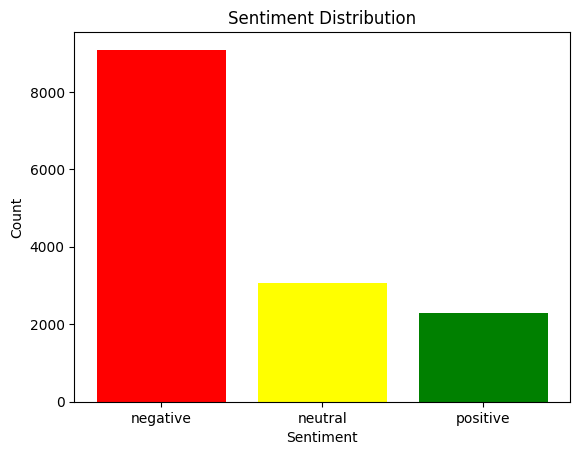

In [ ]:
sentiment_counts = df2['airline_sentiment'].value_counts()

colors = {'negative': 'red', 'neutral': 'yellow', 'positive': 'green'}

plt.bar(sentiment_counts.index, sentiment_counts, color=[colors[s] for s in sentiment_counts.index])

plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')

plt.show()

**Convert the airline_sentiment label to numerical values**

In [ ]:
# map text airline_sentiment to numbers
target_map = {'positive': 1, 'negative': 0, 'neutral': 2}

# remove any trailing whitespace(s)
df2['airline_sentiment'] = df2['airline_sentiment'].str.strip()

# apply the mapping
df2['airline_sentiment'] = df2['airline_sentiment'].map(target_map)

In [ ]:
# check
df2.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,2
1,@VirginAmerica plus you've added commercials t...,1
2,@VirginAmerica I didn't today... Must mean I n...,2
3,@VirginAmerica it's really aggressive to blast...,0
4,@VirginAmerica and it's a really big bad thing...,0


## **Exploratory Data Analysis**

In [ ]:
# import libraries to visualize wordclouds
from wordcloud import WordCloud, STOPWORDS

**Word Cloud for Negative Reviews**

In [ ]:
# get negative reviews
negative_reviews = df2[df2['airline_sentiment'] == 0]

# join the negative reviews using space seperator to convert all rows into one string
words = ' '.join(negative_reviews['text'])

# remove the \n characters from the words output
cleaned_word = ' '.join([word for word in words.split()])

In [ ]:
# create the word cloud
word_cloud = WordCloud(stopwords = STOPWORDS,
                      colormap = 'RdBu',
                      background_color = 'white',
                      width = 3000,
                      height = 2500
                     ).generate(cleaned_word)

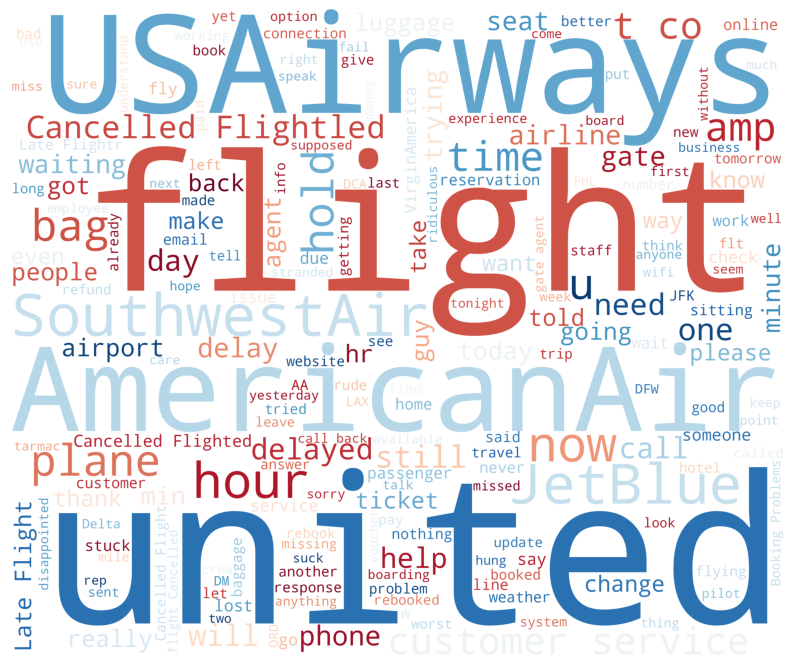

In [ ]:
# show the word cloud
plt.figure(1, figsize = (10, 10))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

- The names of the Airlines are prominent in this word cloud i.e USAirways, AmericanAir, United, AmericanAir.
- Some of the negative words are Cancelled Flight, delayed, Late Flight, boarding problem, stuck,... just to mention a few.

**Word Cloud for Positive Reviews**

In [ ]:
# get positive reviews
positive_reviews = df2[df2['airline_sentiment'] == 1]

# join the positive reviews using space seperator to convert all rows into one string
words = ' '.join(positive_reviews['text'])

# remove the \n characters from the words output
cleaned_word= ' '.join([word for word in words.split()])

In [ ]:
# create the word cloud
word_cloud = WordCloud(stopwords = STOPWORDS,
                      colormap = 'RdBu',
                      background_color = 'white',
                      width = 3000,
                      height = 2500
                     ).generate(cleaned_word)

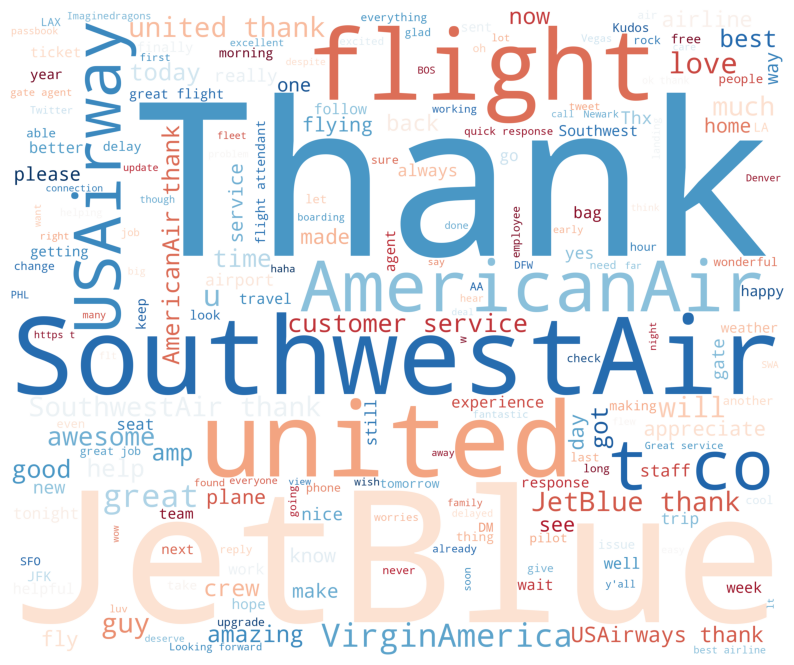

In [ ]:
# show the word cloud
plt.figure(1, figsize = (10, 10))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

- The names of the Airlines dominate as expected.
- Some of the positive words are Best, Love, Amazing, nice, Awesome,... to mention a few

## **Data Preprocessing**

In [ ]:
# import regular expressions to extract the data
import re

In [ ]:
# function removes any character that isn't an alphabet
def remove_special_chars(some_text):
  some_text = re.sub('[^a-zA-Z]', ' ', some_text)
  return some_text

df2['text'] = df2['text'].apply(lambda x: remove_special_chars(x))

In [ ]:
df2.head()

,text,airline_sentiment
0,VirginAmerica What dhepburn said,2
1,VirginAmerica plus you ve added commercials to the experience tacky,1
2,VirginAmerica I didn t today Must mean I need to take another trip,2
3,VirginAmerica it s really aggressive to blast obnoxious entertainment in your guests faces amp they have little recourse,0
4,VirginAmerica and it s a really big bad thing about it,0


In [ ]:
# !pip install contractions
# fix the contractions
import contractions

def replace_contractions(some_text):
  return contractions.fix(some_text)

df2['text'] = df2['text'].apply(lambda x: replace_contractions(x))

In [ ]:
# Import the NLTK Library
import nltk

# nltk.download('punkt')

In [ ]:
# tokenize the text
df2['text'] = df2.apply(lambda row: nltk.word_tokenize(row['text']), axis = 1)

In [ ]:
df2.head()

,text,airline_sentiment
0,"[VirginAmerica, What, dhepburn, said]",2
1,"[VirginAmerica, plus, you, ve, added, commercials, to, the, experience, tacky]",1
2,"[VirginAmerica, I, didn, t, today, Must, mean, I, need, to, take, another, trip]",2
3,"[VirginAmerica, it, s, really, aggressive, to, blast, obnoxious, entertainment, in, your, guests, faces, amp, they, have, little, recourse]",0
4,"[VirginAmerica, and, it, s, a, really, big, bad, thing, about, it]",0


In [ ]:
# convert text to lowercase
def to_lowercase(row):
  words = [word.lower() for word in row]
  return words

df2['text'] = df2['text'].apply(lambda x: to_lowercase(x))

In [ ]:
df2.head()

,text,airline_sentiment
0,"[virginamerica, what, dhepburn, said]",2
1,"[virginamerica, plus, you, ve, added, commercials, to, the, experience, tacky]",1
2,"[virginamerica, i, didn, t, today, must, mean, i, need, to, take, another, trip]",2
3,"[virginamerica, it, s, really, aggressive, to, blast, obnoxious, entertainment, in, your, guests, faces, amp, they, have, little, recourse]",0
4,"[virginamerica, and, it, s, a, really, big, bad, thing, about, it]",0


In [ ]:
# remove stopwords
# nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words("english")

def remove_stopwords(row):
  words = [word for word in row if word not in stop_words]
  return words

df2['text'] = df2['text'].apply(lambda x: remove_stopwords(x))

In [ ]:
df2.head()

,text,airline_sentiment
0,"[virginamerica, dhepburn, said]",2
1,"[virginamerica, plus, added, commercials, experience, tacky]",1
2,"[virginamerica, today, must, mean, need, take, another, trip]",2
3,"[virginamerica, really, aggressive, blast, obnoxious, entertainment, guests, faces, amp, little, recourse]",0
4,"[virginamerica, really, big, bad, thing]",0


In [ ]:
# import Library needed for Lemmatization
from nltk.stem import WordNetLemmatizer

# nltk.download("wordnet")

In [ ]:
# apply Lemmatization
lm = WordNetLemmatizer()

def lemmatize_words(row):
  words = [lm.lemmatize(word) for word in row]
  return words

df2['text'] = df2['text'].apply(lambda x: lemmatize_words(x))

In [ ]:
df2.head()

,text,airline_sentiment
0,"[virginamerica, dhepburn, said]",2
1,"[virginamerica, plus, added, commercial, experience, tacky]",1
2,"[virginamerica, today, must, mean, need, take, another, trip]",2
3,"[virginamerica, really, aggressive, blast, obnoxious, entertainment, guest, face, amp, little, recourse]",0
4,"[virginamerica, really, big, bad, thing]",0


## **Rejoin the Words**

In [ ]:
def join_words(row):
  words = ' '.join([word for word in row])
  return words

df2['text'] = df2['text'].apply(lambda x: join_words(x))

In [ ]:
df2.head()

,text,airline_sentiment
0,virginamerica dhepburn said,2
1,virginamerica plus added commercial experience tacky,1
2,virginamerica today must mean need take another trip,2
3,virginamerica really aggressive blast obnoxious entertainment guest face amp little recourse,0
4,virginamerica really big bad thing,0


In [ ]:
# to split the data in train and test
from sklearn.model_selection import train_test_split

# to create the Sequential model
from tensorflow.keras.models import Sequential

# to create the tokens from the text data
from tensorflow.keras.preprocessing.text import Tokenizer

# to pad the sequences into the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Layers that will be used to implement the LSTM model
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

**Tokenize and convert the airline_sentiment to Numerical vectors**

In [ ]:
# Create tokenizer with 1000 vocabulary size
tokenizer = Tokenizer(num_words = 1000, split = ' ')

tokenizer.fit_on_texts(df2['text'].values)

# converting text to sequences
X = tokenizer.texts_to_sequences(df2['text'].values)

# Padding the sequences
X = pad_sequences(X, 100)

In [ ]:
# save the tokenizer
import pickle

with open ('/content/drive/MyDrive/Saved_Models/tokenizer.pkl', 'wb') as handle:
  pickle.dump(tokenizer, handle)

## **Build the Model**

In [ ]:
# define model architecture for LSTM
model = Sequential()
# add embedding layer to convert text into numerical vectors
model.add(Embedding(1000, 120, input_length = 100))
# add drop out for regularization
model.add(SpatialDropout1D(0.2))
# add the LSTM layer with drop out
model.add(LSTM(150, dropout = 0.2, recurrent_dropout = 0.2))
# output layer
model.add(Dense(3, activation = 'softmax'))

# compile model
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 120)          120000    
                                                                 
 spatial_dropout1d (Spatial  (None, 100, 120)          0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 150)               162600    
                                                                 
 dense (Dense)               (None, 3)                 453       
                                                                 
Total params: 283053 (1.08 MB)
Trainable params: 283053 (1.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Split the Data**

In [ ]:
# creating the target feature
y = df2['airline_sentiment']

# split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 10)

In [ ]:
# encode target
from tensorflow.keras.utils import to_categorical

y_train_enc = to_categorical(y_train, num_classes = 3)
y_test_enc = to_categorical(y_test, num_classes = 3)

**Model Training**

In [ ]:
# define parameters for training
model_path = '/content/drive/MyDrive/Saved_Models/NLP_airline_model.h5'
es = EarlyStopping(patience = 3, verbose=1, monitor = "val_loss")
chkpt = ModelCheckpoint(model_path, verbose = 1, save_best_only = True)

In [ ]:
batch_size = 32

# fit the model on training data with 20 epochs
history = model.fit(X_train, y_train_enc, epochs = 20, batch_size = batch_size, callbacks=[es, chkpt], verbose = 1,
                validation_split = 0.1)

Epoch 1/20
366/366 [==============================] - ETA: 0s - loss: 0.6611 - accuracy: 0.7305
Epoch 1: val_loss improved from inf to 0.56721, saving model to /content/drive/MyDrive/Saved_Models/NLP_airline_model.h5
366/366 [==============================] - 158s 422ms/step - loss: 0.6611 - accuracy: 0.7305 - val_loss: 0.5672 - val_accuracy: 0.7656
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


366/366 [==============================] - ETA: 0s - loss: 0.5065 - accuracy: 0.7954
Epoch 2: val_loss improved from 0.56721 to 0.54521, saving model to /content/drive/MyDrive/Saved_Models/NLP_airline_model.h5
366/366 [==============================] - 153s 417ms/step - loss: 0.5065 - accuracy: 0.7954 - val_loss: 0.5452 - val_accuracy: 0.7786
Epoch 3/20
366/366 [==============================] - ETA: 0s - loss: 0.4813 - accuracy: 0.8048
Epoch 3: val_loss did not improve from 0.54521
366/366 [==============================] - 153s 418ms/step - loss: 0.4813 - accuracy: 0.8048 - val_loss: 0.5470 - val_accuracy: 0.7725
Epoch 4/20
366/366 [==============================] - ETA: 0s - loss: 0.4649 - accuracy: 0.8103
Epoch 4: val_loss improved from 0.54521 to 0.54493, saving model to /content/drive/MyDrive/Saved_Models/NLP_airline_model.h5
366/366 [==============================] - 150s 409ms/step - loss: 0.4649 - accuracy: 0.8103 - val_loss: 0.5449 - val_accuracy: 0.7756
Epoch 5/20
366/366 [=